# Importing libraries

In [1]:
from sklearn import tree, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2, SelectPercentile
from sklearn.feature_selection import VarianceThreshold

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from timeit import default_timer as timer
from datetime import timedelta

# 0.1 Helper functions

In [2]:
def normalizer(X):
    # Input: X feature matrix
    # Output: Normalized X feature matrix
    
    # We know the maximum value a feature can have is 255.
    maxval = 255
    
    # Divide all the entries by this maximum value to get a number between 0 and 1
    X = X/maxval
    
    return X

In [3]:
def data_splitter(X,y):
    # Input: X feature matrix, y target matrix
    # Ouput: Training, testing and validation data
    
    # I define a function which can split our dataset into training-, validation- and testdata.
    # It does NOT shuffle the data before splitting.                 
    
    # Shuffle and split the data into train and a concatenation of validation and test sets
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
    
    # Shuffle and split the data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=True, random_state=1)                                                                   

    return X_train, X_val, X_test, y_train, y_val, y_test

# 1.1 Data

# 1.1.1 Preprocessing data

In [4]:
# Load the dataset as a pandas dataframe
dataset_imgs = pd.read_csv('handwritten_digits_images.csv', header=None)
dataset_labels = pd.read_csv('handwritten_digits_labels.csv', header=None)

# Extract features to a pandas dataframe X then convert to a numpy array
X = dataset_imgs.to_numpy()

# Extract labels to a pandas dataframe y then convert to a numpy array
y = dataset_labels.to_numpy()

# Normalize the features to values ranging from 0 to 1
X = normalizer(X)

print('Number of samples: ', X.shape[0])
print('Number of features: ', X.shape[-1])
print('Number of labels: ', y.shape[0])

Number of samples:  70000
Number of features:  784
Number of labels:  70000


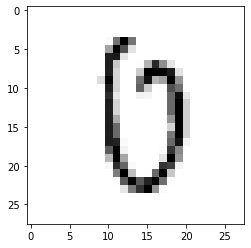

In [5]:
plt.imshow(X[0].reshape(28,28), cmap='Greys')

In [6]:
print(y[0])

[0]


In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = data_splitter(X,y) 

In [8]:
print('Shape of training data:   ', X_train.shape)
print('Shape of validation data: ', X_val.shape)
print('Shape of testing data:    ', X_test.shape)

Shape of training data:    (49000, 784)
Shape of validation data:  (10500, 784)
Shape of testing data:     (10500, 784)


# 1.1.2 Feature selection

In [9]:
# Define our first feature seletor as a VarianceThreshold feature selector
# Then fit it using the training data at the same time transforming the training data.
# Then use the fitted selector to remove features from the validation and test data
feature_selector_1 = VarianceThreshold(threshold=0)
X_new_train = feature_selector_1.fit_transform(X_train)
X_new_val = feature_selector_1.transform(X_val)
X_new_test = feature_selector_1.transform(X_test)

# Define our first feature seletor as a SelectPercentile feature selector
# Then fit it using the training data and training labels at the same time transforming the training data.
# Then use the fitted selector to remove features from the modified validation and test data
feature_selector_2 = SelectPercentile(chi2, percentile=50)
X_new_train = feature_selector_2.fit_transform(X_new_train, y_train)
X_new_val = feature_selector_2.transform(X_new_val)
X_new_test = feature_selector_2.transform(X_new_test)

In [10]:
print('Shape of training data after feature selection:   ', X_new_train.shape)
print('Shape of validation data after feature selection: ', X_new_val.shape)
print('Shape of test data after feature selection:       ', X_new_test.shape)

Shape of training data after feature selection:    (49000, 355)
Shape of validation data after feature selection:  (10500, 355)
Shape of test data after feature selection:        (10500, 355)


In [11]:
def transform_features(X, fs_1, fs_2):
    # Input: Feature matrix, and two feature selectors
    # Ouput: Feature matrix with only selected features remaining
    
    # Remove certain features using the first feature selector
    modified_X = fs_1.transform(X)
    
    # Then remove other features using the second feature selector
    modified_X = fs_2.transform(modified_X)
    
    return modified_X

# 1.2 Code

# 1.2.1 Model selector function

In [12]:
def model_selector(model, parameters, X, y, verbose=2, n_jobs=-1):
    # Inputs: A candidate model, its different parameters, training data
    # Outputs: The best model, its parameters, its score during training, the elapsed time of training
    
    # Create a GridSearch model selector with given estimator and parameter grid
    selector = GridSearchCV(estimator=model, param_grid=parameters, verbose=verbose, n_jobs=n_jobs)
    
    # Start timer, fit the selector to data. End timer when complete
    start = timer()
    selector.fit(X, y.ravel())
    end = timer()
    
    # The elapsed time in hours:minutes:seconds:milliseconds
    elapsed_time = timedelta(seconds=end-start)
    
    # Extract the best training score, the best parameters and the best model for this type of estimator
    best_score = selector.best_score_
    best_params = selector.best_params_
    best_model = selector.best_estimator_
    
    return best_model, best_params, best_score, elapsed_time

# 1.2.2 Full model selector

In [13]:
# Create a list of candidate models
model_list = [SGDClassifier(random_state=0), SVC(random_state=0), 
              RandomForestClassifier(random_state=0), MLPClassifier(random_state=0)]

# Create a list of model names
model_names = ['Stochastic Gradient Descent Classifier', 'Support Vector Classifier', 'Random Forest Classifier'
              , 'Multi-Layer Perceptron Classifier']

# Create dictionaries of hyperparameters to vary for the respective candidate models
SGD_parameters = {'loss':['hinge', 'log', 'modified_huber'], 'penalty':['l2', 'l1', 'elasticnet'], 'alpha':[0.0001, 0.01, 0.1]}
SVC_parameters = {'kernel':['linear', 'poly', 'rbf'], 'C':[0.01, 0.1, 1, 10]}
RNDF_parameters= {'n_estimators':[100, 200, 300], 'criterion':['gini', 'entropy'], 'max_depth':[None, 5, 10, 25]}
MLP_parameters = {'hidden_layer_sizes':[(128,128), (128,128,128), (256,256), (256,256,256)], 'alpha':[0.0001, 0.01, 0.1]}

# Create a list of respective hyperparameter dictionaries
parameter_list = [SGD_parameters, SVC_parameters, RNDF_parameters, MLP_parameters]

# Initialize variables
best_model_list = []
best_params_list = []
best_score_list = []
elapsed_time_list = []

# Start timer
start = timer()

# For each model in the model list, vary the hyperparameters and select the best model based on the score on the kFold
# training data. Then evaluate the best model on the validation data. 
for i in range(len(model_list)):
    
    # Aquire the best model and its hyperparameters for each candidate model
    best_model, best_params, best_score, elapsed_time = model_selector(model_list[i], parameter_list[i], X_new_train, y_train, 
                                                                       verbose=3, n_jobs=-1)
    # Append the information to the lists
    best_model_list.append(best_model)
    best_params_list.append(best_params)
    best_score_list.append(best_score)
    elapsed_time_list.append(elapsed_time)

# End timer
end = timer()

# Save the total elapsed time for model selection
total_elapsed_time = timedelta(seconds=end-start)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 13.1min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 111.5min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 20.0min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 53.4min finished


# 1.2.3 Performance of candidate models & the final selected model

The total time spend doing model selection was:  3:24:02.099158
The model selection time for the  Stochastic Gradient Descent Classifier  was:  0:13:21.166263
The best  Stochastic Gradient Descent Classifier  scored:  0.9048979591836733  on the kFold training data.
The best parameters were:  {'alpha': 0.0001, 'loss': 'log', 'penalty': 'elasticnet'}
The validation score of the best  Stochastic Gradient Descent Classifier  is:  0.9072380952380953


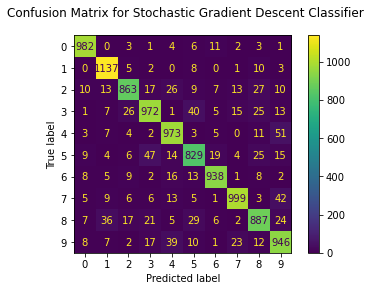

The model selection time for the  Support Vector Classifier  was:  1:53:21.981255
The best  Support Vector Classifier  scored:  0.9811020408163265  on the kFold training data.
The best parameters were:  {'C': 10, 'kernel': 'rbf'}
The validation score of the best  Support Vector Classifier  is:  0.9815238095238096


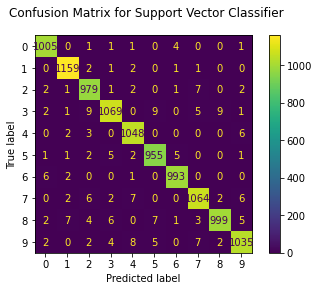

The model selection time for the  Random Forest Classifier  was:  0:21:17.163235
The best  Random Forest Classifier  scored:  0.964938775510204  on the kFold training data.
The best parameters were:  {'criterion': 'gini', 'max_depth': 25, 'n_estimators': 300}
The validation score of the best  Random Forest Classifier  is:  0.9681904761904762


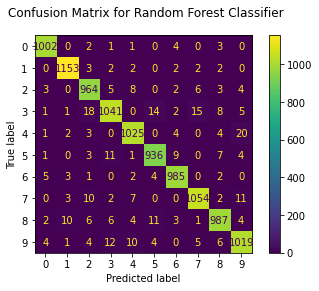

The model selection time for the  Multi-Layer Perceptron Classifier  was:  0:56:01.787849
The best  Multi-Layer Perceptron Classifier  scored:  0.9780612244897959  on the kFold training data.
The best parameters were:  {'alpha': 0.01, 'hidden_layer_sizes': (256, 256)}
The validation score of the best  Multi-Layer Perceptron Classifier  is:  0.9788571428571429


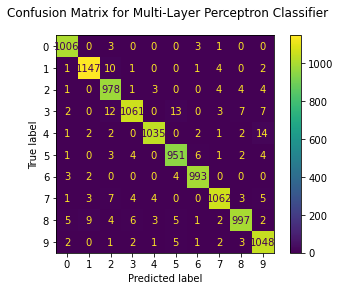

In [14]:
# Initialize the best validation score
best_val_score = 0

print('The total time spend doing model selection was: ', total_elapsed_time)

# For each of the best models, compute the validation score. Print model name, elapsed time, the optimal parameters and
# the models score on validation data. Then plot the confusion matrix for the validation data with the model. 
# Then score whatever model achieved the highest validation score as the selected_model
for i in range(len(best_model_list)):
    
    val_score = best_model_list[i].score(X_new_val, y_val.ravel())

    print('The model selection time for the ', model_names[i], ' was: ', elapsed_time_list[i])
    print('The best ', model_names[i], ' scored: ', best_score_list[i], ' on the kFold training data.')
    print('The best parameters were: ', best_params_list[i])
    print('The validation score of the best ', model_names[i], ' is: ', val_score)
    
    # Plot the confusion matrix for the current model on the validation data
    disp = metrics.plot_confusion_matrix(best_model_list[i], X_new_val, y_val)
    disp.figure_.suptitle('Confusion Matrix for ' + str(model_names[i]))
    
    plt.show()
    
    # Find the best model by comparing current validation score to the previous best
    if val_score > best_val_score:

        selected_model = best_model_list[i]
        selected_model_params = best_params_list[i]
        selected_score = val_score
        selected_time = elapsed_time_list[i]
        selected_model_name = model_names[i]
        best_val_score = val_score


We have that the selected model is,

In [15]:
print('The selected model is: ', selected_model_name)
print('The parameters of the selected model are: ', selected_model_params)

The selected model is:  Support Vector Classifier
The parameters of the selected model are:  {'C': 10, 'kernel': 'rbf'}


# 1.2.4 Selected model accuracy on unseen data

In [16]:
# Get predicted performance of selected model on unseen data
test_score = selected_model.score(X_new_test, y_test.ravel())

# Print the results
print('The final selected model is: ', selected_model_name)
print('With the hyperparameters: ', selected_model_params)
print('This model had the score of: ', selected_score, ' on the validation data')
print('This model has a score of: ', test_score, ' on unseen test data')

The final selected model is:  Support Vector Classifier
With the hyperparameters:  {'C': 10, 'kernel': 'rbf'}
This model had the score of:  0.9815238095238096  on the validation data
This model has a score of:  0.9833333333333333  on unseen test data


# 1.2.5 Predict and plot

In [59]:
def predict_plot(model, data_row, normalize=False):
    # Input: A model, a data sample (image), and wether or not to normalize the data.
    # Output: Label for the image, the models prediction of the label, a plot of the image
    # Used to predict unseen data we dont have the label to.
    
    # If we need the data to be normalized first, set normalize to True. If the data is already normalized,
    # set normalize to False.
    if normalize == True:
        data_row = normalizer(data_row)
    
    # Do feature selection on raw data. Then make prediction.
    data_row_mod = transform_features(data_row.reshape(1, -1), feature_selector_1, feature_selector_2)
    prediction = model.predict(data_row_mod)
             
    print('The estimator has predicted the number: ', prediction)
        
    print('The actual number looks like,')
    plt.imshow(data_row.reshape(28,28), cmap='Greys')

The estimator has predicted the number:  [7]
The actual number looks like,


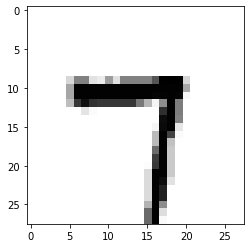

In [60]:
predict_plot(selected_model, X_test[0])

# 1.2.6 Implementation

In [61]:
# Load the data again as toydata
toydata_imgs = pd.read_csv('handwritten_digits_images.csv', header=None)
X_toy = toydata_imgs.to_numpy()

The estimator has predicted the number:  [9]
The actual number looks like,


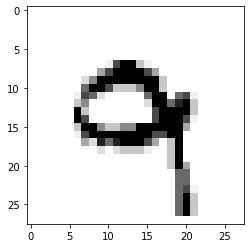

In [62]:
# Predict and plot any of the samples in the toydata

sample_idx =  63456

predict_plot(selected_model, X_toy[sample_idx], normalize=True)